# 1. Perkenalan

**Nama**     : Muhammad Vincar Rafi Theoseta <br>
**Batch**    : HCK-18 <br>
**Dataset**  : ftds-hacktiv8-project.phase1_ftds_018_hck.credit-card-information <br>
**Objective**: Membuat model clustering untuk membagi data ke dalam segmen-segmen berdasarkan data kartu kredit 6 bulan terakhir<br>

# 2. Query

```py
# access bigquery
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')
project_id = "myproject-427010"
client = bigquery.Client(project=project_id)
```

```py
# query from bigquery-public-data.ml_datasets.credit_card_default
df = client.query('''

SELECT * 
FROM `ftds-hacktiv8-project.phase1_ftds_018_hck.credit-card-information`
WHERE MOD(CUST_ID, 2) = 0

''').to_dataframe()
```


| column_name                 | data_type | description                                                                                      |
|-----------------------------|-----------|--------------------------------------------------------------------------------------------------|
| CUST_ID                     | INT64     | Identification of Credit Card holder                                                             |
| BALANCE                     | FLOAT64   | Balance amount left in their account to make purchases                                           |
| BALANCE_FREQUENCY           | FLOAT64   | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) |
| PURCHASES                   | FLOAT64   | Amount of purchases made from account                                                            |
| ONEOFF_PURCHASES            | FLOAT64   | Maximum purchase amount done in one-go                                                           |
| INSTALLMENTS_PURCHASES      | FLOAT64   | Amount of purchase done in installment                                                           |
| CASH_ADVANCE                | FLOAT64   | Cash in advance given by the user                                                                |
| PURCHASES_FREQUENCY         | FLOAT64   | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| ONEOFF_PURCHASES_FREQUENCY  | FLOAT64   | How frequently Purchases are happening in one-go (0 to 1 scale, higher means more frequent)     |
| PURCHASES_INSTALLMENTS_FREQUENCY | FLOAT64 | How frequently purchases in installments are being done (0 to 1 scale, higher means more frequent) |
| CASH_ADVANCE_FREQUENCY      | FLOAT64   | How frequently the cash in advance being paid (0 to 1 scale, higher means more frequent)        |
| CASH_ADVANCE_TRX            | INT64     | Number of Transactions made with 'Cash in Advanced'                                              |
| PURCHASES_TRX               | INT64     | Number of purchase transactions made                                                             |
| CREDIT_LIMIT                | FLOAT64   | Limit of Credit Card for user                                                                    |
| PAYMENTS                    | FLOAT64   | Amount of Payment done by user                                                                   |
| MINIMUM_PAYMENTS            | FLOAT64   | Minimum amount of payments made by user                                                          |
| PRC_FULL_PAYMENT            | FLOAT64   | Percent of full payment paid by user                                                             |
| TENURE                      | INT64     | Tenure of credit card service for user                                                           |


# 3. Import Library

In [62]:
# basic use
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
# feature engineering
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
# pipeline
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.pipeline import make_pipeline
# model saving
import pickle
# warnings
import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

# 4. Data Loading

Loading data dari file csv hasil query

In [63]:
# read csv
df = pd.read_csv('/Users/vincartheoseta/Hacktiv/Phase 1/GC6/p1-ftds018-hck-g6-vincar12/P1G6_Set_1_Vincar.csv')

Tunjukkan 10 data teratas

In [64]:
# show top 10 data
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,0.875000,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,0.125000,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,1.000000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,1.000000,1450.0,1450.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,397.090516,227.143184,0.0,8
5,4266,2237.238086,1.000000,120.0,120.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2500.0,343.102984,712.986387,0.0,8
6,4360,2730.843802,1.000000,2900.0,2900.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2900.0,0.000000,NaN,0.0,8
7,4680,424.994385,0.375000,1200.0,1200.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,57.266292,56.720210,0.0,8
8,5884,18.885677,0.375000,57.0,57.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
9,24,0.004816,0.545455,51.7,0.0,51.7,0.0,0.250,0.000,0.250,0.0,0,3,3000.0,33.249088,0.059481,0.0,12


Tunjukkan 10 data paling bawah

In [65]:
# show last 10 data
df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,1588,538.768762,0.909091,226.95,129.58,97.37,452.009130,0.545455,0.090909,0.454545,0.272727,8,9,1200.0,946.649324,211.220001,0.000000,11
4466,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.000000,11
4467,2528,427.642111,0.888889,0.00,0.00,0.00,2563.705644,0.000000,0.000000,0.000000,0.888889,62,0,1200.0,2853.967334,146.976542,0.500000,9
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.000000,9
4469,2152,1420.727073,1.000000,0.00,0.00,0.00,311.804499,0.000000,0.000000,0.000000,0.900000,9,0,1500.0,506.765033,449.179818,0.000000,10
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11
4474,3564,1977.007090,1.000000,1032.04,226.90,805.14,4335.919227,0.909091,0.090909,0.818182,0.545455,21,17,4000.0,3056.424974,910.707525,0.090909,11


Cek info dari dataset

In [66]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

Insight:
- 4475 baris data
- 18 kolom
- Semua data berupa numerik dengan 14 float dan 4 integer
- Missing value pada kolom `MINIMUM_PAYMENTS` dan `CREDIT_LIMIT`

Cek data terduplikat

In [67]:
# check for duplicates
df.duplicated().sum()

0

Insight:
- Tidak ada data yang terduplikat

# 5. Exploratory Data Analysis

Eksplorasi data dengan tujuan memahami data lebih dalam. Dimulai dengan menyalin data agar data asli tetap tersimpan

In [68]:
# copy data from original data
df1 = df.copy()

## 5.1. Missing Values

Cek info dari missing values dari dataset

In [69]:
missing = df1.isnull().sum()
missing

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Insight:
- 158 data missing dari kolom `MINIMUM_PAYMENTS`
- 1 data missing darikolom `CREDIT_LIMIT`

Tampilkan data yang memiliki nilai missing

In [70]:
# show missing value rows
null_data = df1[df1.isnull().any(axis=1)]
null_data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0,2,1200.0,0.0,NaN,0.0,8
2,2322,1.979916,0.125000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.0,NaN,0.0,8
6,4360,2730.843802,1.000000,2900.00,2900.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,2900.0,0.0,NaN,0.0,8
8,5884,18.885677,0.375000,57.00,57.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.0,NaN,0.0,8
27,1830,0.000000,0.000000,66.75,0.00,66.75,0.000000,0.250000,0.000000,0.250000,0.000000,0,3,4000.0,0.0,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,7492,2242.311686,1.000000,437.00,97.00,340.00,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.0,NaN,0.0,12
4087,4290,1948.434315,1.000000,324.30,324.30,0.00,1468.083560,0.166667,0.166667,0.000000,0.166667,4,4,5000.0,0.0,NaN,0.0,12
4091,5468,4618.091584,1.000000,541.68,541.68,0.00,3580.753362,0.166667,0.166667,0.000000,0.166667,2,2,8500.0,0.0,NaN,0.0,12
4144,4234,27.716642,0.100000,0.00,0.00,0.00,480.104401,0.000000,0.000000,0.000000,0.100000,1,0,5000.0,0.0,NaN,0.0,10


Tampilkan kardinalitas data yang missing

In [71]:
# create empty lists
columns = []
nunique = []
unique = []

# loop columns
for column in null_data:
    # inserting data to empty lists
    columns.append(column)
    nunique.append(null_data[column].nunique())
    unique.append(null_data[column].unique())

# create dataframe for the lists
cardinality_df = pd.DataFrame({
    'column name' : columns,
    'unique value count' : nunique,
    'unique value list' : unique
})

cardinality_df

,column name,unique value count,unique value list
0,CUST_ID,159,"[788, 2322, 4360, 5884, 1830, 2068, 5746, 6718..."
1,BALANCE,127,"[16.581535, 1.979916, 2730.843802, 18.885677, ..."
2,BALANCE_FREQUENCY,23,"[0.125, 1.0, 0.375, 0.0, 0.090909, 0.272727, 0..."
3,PURCHASES,118,"[200.0, 80.0, 2900.0, 57.0, 66.75, 31.5, 143.7..."
4,ONEOFF_PURCHASES,63,"[0.0, 80.0, 2900.0, 57.0, 213.34, 1283.9, 815...."
5,INSTALLMENTS_PURCHASES,75,"[200.0, 0.0, 66.75, 31.5, 143.73, 64.62, 188.0..."
6,CASH_ADVANCE,65,"[0.0, 389.594394, 1365.18629, 1625.784248, 462..."
7,PURCHASES_FREQUENCY,24,"[0.125, 0.25, 0.5, 0.75, 1.0, 0.083333, 0.5555..."
8,ONEOFF_PURCHASES_FREQUENCY,15,"[0.0, 0.125, 0.25, 0.166667, 1.0, 0.083333, 0...."
9,PURCHASES_INSTALLMENTS_FREQUENCY,23,"[0.125, 0.0, 0.25, 0.166667, 0.5, 0.416667, 0...."


Insight:
- Kemiripan semua nilai missing terdapat pada kolom `PRC_FULL_PAYMENT`

Cek missing value untuk kolom `CREDIT_LIMIT`

In [72]:
df1[df1['CREDIT_LIMIT'].isnull()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3843,4956,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


Insight:
- Tidak terlihat hubungan signifikan antara missing value dengan yang lain

Cek missing value kolom `MINIMUM_PAYMENTS`

In [73]:
df1[df1['MINIMUM_PAYMENTS'].isnull()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0,2,1200.0,0.0,NaN,0.0,8
2,2322,1.979916,0.125000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.0,NaN,0.0,8
6,4360,2730.843802,1.000000,2900.00,2900.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,2900.0,0.0,NaN,0.0,8
8,5884,18.885677,0.375000,57.00,57.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.0,NaN,0.0,8
27,1830,0.000000,0.000000,66.75,0.00,66.75,0.000000,0.250000,0.000000,0.250000,0.000000,0,3,4000.0,0.0,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,7492,2242.311686,1.000000,437.00,97.00,340.00,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.0,NaN,0.0,12
4087,4290,1948.434315,1.000000,324.30,324.30,0.00,1468.083560,0.166667,0.166667,0.000000,0.166667,4,4,5000.0,0.0,NaN,0.0,12
4091,5468,4618.091584,1.000000,541.68,541.68,0.00,3580.753362,0.166667,0.166667,0.000000,0.166667,2,2,8500.0,0.0,NaN,0.0,12
4144,4234,27.716642,0.100000,0.00,0.00,0.00,480.104401,0.000000,0.000000,0.000000,0.100000,1,0,5000.0,0.0,NaN,0.0,10


Insight:
- Terlihat semua kolom `PRC_FULL_PAYMENT` bernilai 0

Cek semua kolom `PRC_FULL_PAYMENT` yang bernilai 0

In [74]:
df1[df1['PRC_FULL_PAYMENT'] == 0]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,0.125000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,1588,538.768762,0.909091,226.95,129.58,97.37,452.009130,0.545455,0.090909,0.454545,0.272727,8,9,1200.0,946.649324,211.220001,0.0,11
4466,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.0,11
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.0,9
4469,2152,1420.727073,1.000000,0.00,0.00,0.00,311.804499,0.000000,0.000000,0.000000,0.900000,9,0,1500.0,506.765033,449.179818,0.0,10


Insight:
- Kurang terlihat hubungan antara `PRC_FULL_PAYMENT` yang bernilai 0 dengan missing value
- Data dengan `PRC_FULL_PAYMENT` bernilai 0 sangat banyak yang tidak memiliki missing value
- Bisa ditarik kesimpulan data berupa MCAR

In [75]:
print('Percentage missing values: ', len(null_data)/len(df1))

Percentage missing values:  0.03553072625698324


## 5.2. Rata-rata Jumlah Pembelian per Tenure

Cek rata-rata jumlah pembelian oleh customer berdasarkan tenure

In [76]:
# grouping by education_level and counting default_payment_next_month
topfreq = df1.groupby("TENURE")["PURCHASES"].mean().sort_values(ascending=False)
topfreq = topfreq.reset_index()

# bar chart
fig = px.bar(topfreq, x="TENURE", y="PURCHASES", orientation='v', text_auto='.2s', title='Rata-rata Jumlah Pembelian per Tenure')
fig.update_layout(title_x = 0.5)
fig.update_yaxes(title_text="Rata-rata Jumlah Pembelian")
fig.update_xaxes(title_text="Tenure")

# display bar chart and grouping data
fig.show()
topfreq

,TENURE,PURCHASES
0,12,1089.702270
1,11,597.291024
2,10,536.483860
3,9,515.425568
4,8,477.973299
5,7,470.298300
6,6,403.658252


Insight:
- Rata-rata jumlah pembelian tertinggi pada customer dengan tenure 12 bulan dengan 1089.7 pembelian
- Terkecil pada tenure 6 bulan dengan 403.6 pembelian
- Dapat dilihat tren yang meningkat berdasarkan lama tenure
- Dapat ditarik informasi bahwa semakin lama tenure atau waktu pelunasan maka pembelian akan meningkat, ini dapat dikarenakan customer-customer lebih yakin dapat melunaskan pinjaman jika waktu masih lama dibanding waktu yang lebih pendek

## 5.3. Jumlah Customer Berdasarkan Frekuensi Pembelian

Kategorisasi customer berdasarkan frekuensi pembelian, dimana:
- 1 = selalu beli
- 0.5 - 1 = sering beli
- 0.1 - 0.4 = jarang beli
- 0 = tidak pernah beli


In [77]:
#select chol column
pfreq = df1.PURCHASES_FREQUENCY

#empty list
category = []

#loop item in column
for item in pfreq:
    if item == 1: category.append("Always")
    elif 1> item >= 0.5: category.append("Often")
    elif 0< item < 0.5: category.append("Sometimes")
    else: category.append("Never")

#add new column
df1["PURCHASES_FREQUENCY_CAT"] = category

Cek jumlah customer berdasarkan frekuensi pembelian dengan groupby dan count, dan divisualisasikan dengan plotly

In [78]:
# grouping by category and counting price
toppfreq = df1.groupby("PURCHASES_FREQUENCY_CAT")["CUST_ID"].count().sort_values(ascending=False)
toppfreq = toppfreq.reset_index()
toppfreq

# bar chart figure
fig = px.bar(toppfreq, x="PURCHASES_FREQUENCY_CAT", y="CUST_ID", text_auto='.2s', title='Jumlah Customer Berdasarkan Frekuensi Pembelian')
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Frekuensi Pembelian")
fig.update_yaxes(title_text="Jumlah Customer per Kategori")

# display
fig.show()
toppfreq

,PURCHASES_FREQUENCY_CAT,CUST_ID
0,Often,1189
1,Sometimes,1182
2,Always,1082
3,Never,1022


Insight:
- Jarak antar kategori tidak terlihat berbeda sangat signifikan
- Paling besar jumlah customer pada kategori 'Often' atau sering beli dengan 1189
- Paling kecil jumlah customer pada kategori 'Never' atau tidak pernah beli dengan 1022
- Informasi yang dapat ditarik adalah semua customer memiliki persebaran cukup rata dalam frekuensi pembelian

## 5.4. Jumlah Customer Berdasarkan Frekuensi Pembelian Lunas

Kategorisasi customer berdasarkan frekuensi pembelian yang langsung lunas, dimana:
- 1 = selalu beli
- 0.5 - 1 = sering beli
- 0.1 - 0.4 = jarang beli
- 0 = tidak pernah beli


In [79]:
#select chol column
opfreq = df1.ONEOFF_PURCHASES_FREQUENCY

#empty list
category = []

#loop item in column
for item in opfreq:
    if item == 1: category.append("Always")
    elif 1> item >= 0.5: category.append("Often")
    elif 0< item < 0.5: category.append("Sometimes")
    else: category.append("Never")

#add new column
df1["ONEOFF_PURCHASES_FREQUENCY_CAT"] = category

Cek jumlah customer berdasarkan frekuensi pembelian yang langsung lunas dengan groupby dan count, dan divisualisasikan dengan plotly

In [80]:
# grouping by category and counting price
topofreq = df1.groupby("ONEOFF_PURCHASES_FREQUENCY_CAT")["CUST_ID"].count().sort_values(ascending=False)
topofreq = topofreq.reset_index()
topofreq

# bar chart figure
fig = px.bar(topofreq, x="ONEOFF_PURCHASES_FREQUENCY_CAT", y="CUST_ID", text_auto='.2s', title='Jumlah Customer Berdasarkan Frekuensi Pembelian Lunas')
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Frekuensi Pembelian Lunas")
fig.update_yaxes(title_text="Jumlah Customer per Kategori")

# display
fig.show()
topofreq

,ONEOFF_PURCHASES_FREQUENCY_CAT,CUST_ID
0,Never,2180
1,Sometimes,1500
2,Often,556
3,Always,239


Insight:
- Jarak antar kategori terlihat sangat signifikan
- Paling besar jumlah customer pada kategori 'Never' atau tidak pernah beli lunas dengan 2180
- Disusul kategori 'Sometimes' atau terkadang beli cukup tinggi dengan 1500
- Paling kecil jumlah customer pada kategori 'Always' atau selalu beli dengan 239
- Informasi yang dapat ditarik adalah cukup tinggi data customer yang terkadang beli dengan langsung lunas, yaitu sekitar 33% customer

## 5.5. Jumlah Customer Berdasarkan Frekuensi Pembelian Cicilan

Kategorisasi customer berdasarkan frekuensi pembelian dengan metode cicilan, dimana:
- 1 = selalu beli
- 0.5 - 1 = sering beli
- 0.1 - 0.4 = jarang beli
- 0 = tidak pernah beli


In [81]:
#select chol column
pifreq = df1.PURCHASES_INSTALLMENTS_FREQUENCY

#empty list
category = []

#loop item in column
for item in pifreq:
    if item == 1: category.append("Always")
    elif 1> item >= 0.5: category.append("Often")
    elif 0< item < 0.5: category.append("Sometimes")
    else: category.append("Never")

#add new column
df1["PURCHASES_INSTALLMENTS_FREQUENCY_CAT"] = category

Cek jumlah customer berdasarkan frekuensi pembelian metode cicilan dengan groupby dan count, dan divisualisasikan dengan plotly

In [82]:
# grouping by category and counting price
topifreq = df1.groupby("PURCHASES_INSTALLMENTS_FREQUENCY_CAT")["CUST_ID"].count().sort_values(ascending=False)
topifreq = topifreq.reset_index()
topifreq

# bar chart figure
fig = px.bar(topifreq, x="PURCHASES_INSTALLMENTS_FREQUENCY_CAT", y="CUST_ID", text_auto='.2s', title='Jumlah Customer Berdasarkan Frekuensi Pembelian Cicilan')
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Frekuensi Pembelian dengan Cicilan")
fig.update_yaxes(title_text="Jumlah Customer per Kategori")

# display
fig.show()
topifreq

,PURCHASES_INSTALLMENTS_FREQUENCY_CAT,CUST_ID
0,Never,1946
1,Often,1026
2,Sometimes,827
3,Always,676


Insight:
- Jarak antar kategori terlihat sangat signifikan
- Paling besar jumlah customer pada kategori 'Never' atau tidak pernah beli cicil dengan 1946
- Disusul dengan kategori 'Often' atau seringkali dengan 1026
- Paling kecil jumlah customer pada kategori 'Always' atau selalu beli dengan 676
- Informasi yang dapat ditarik adalah nilai pada kategori 'Often' cukup tinggi dengan 1026 data atau sekitar 22% customer sering membeli dengan cicilan

## 5.8. Jumlah Customer Berdasarkan Frekuensi Pembelian dengan Uang Tunai di Muka

Kategorisasi customer berdasarkan frekuensi pembelian dengan uang tunai di muka, dimana:
- 1 = selalu beli
- 0.5 - 1 = sering beli
- 0.1 - 0.4 = jarang beli
- 0 = tidak pernah beli


In [83]:
#select chol column
cafreq = df1.CASH_ADVANCE_FREQUENCY

#empty list
category = []

#loop item in column
for item in cafreq:
    if item == 1: category.append("Always")
    elif 1> item >= 0.5: category.append("Often")
    elif 0< item < 0.5: category.append("Sometimes")
    else: category.append("Never")

#add new column
df1["CASH_ADVANCE_FREQUENCY_CAT"] = category

Cek jumlah customer berdasarkan frekuensi pembelian metode uang tunai di muka dengan groupby dan count, dan divisualisasikan dengan plotly

In [84]:
# grouping by category and counting price
topcafreq = df1.groupby("CASH_ADVANCE_FREQUENCY_CAT")["CUST_ID"].count().sort_values(ascending=False)
topcafreq = topcafreq.reset_index()
topcafreq

# bar chart figure
fig = px.bar(topcafreq, x="CASH_ADVANCE_FREQUENCY_CAT", y="CUST_ID", text_auto='.2s', title='Jumlah Customer Berdasarkan Frekuensi Pembelian dengan Uang Tunai di Muka')
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Frekuensi Pembelian dengan Uang Tunai di Muka")
fig.update_yaxes(title_text="Jumlah Customer per Kategori")

# display
fig.show()
topcafreq

,CASH_ADVANCE_FREQUENCY_CAT,CUST_ID
0,Never,2323
1,Sometimes,1782
2,Often,356
3,Always,14


Insight:
- Jarak antar kategori terlihat sangat signifikan
- Paling besar jumlah customer pada kategori 'Never' atau tidak pernah dengan 2323
- Disusul dengan kategori 'Sometimes' atau terkadang dengan 1782
- Paling kecil jumlah customer pada kategori 'Always' atau selalu beli dengan 14
- Informasi yang dapat ditarik adalah nilai pada kategori 'Sometimes' cukup tinggi sekitar 39% customer terkadang membeli dengan uang tunai di muka

# 6. Feature Engineering

Feature Engineering bertujuan mengubah data sedemikian rupa sehingga dapat digunakan untuk pembelajaran oleh model. Dimulai dengan menyalin data agar data asli tetap tersimpan

In [85]:
# copy data
df2 = df.copy()

## 6.1. Missing Value Handling

Dikarenakan jumlah data dengan missing value yang rendah hanya 3% dan berupa MCAR, maka data missing akan di drop

In [86]:
# drop missing values
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

In [87]:
# check data
df2

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1902,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,8
1,3426,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,8
2,3976,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,8
3,4266,2237.238086,1.000000,120.00,120.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,2500.0,343.102984,712.986387,0.000000,8
4,4680,424.994385,0.375000,1200.00,1200.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1200.0,57.266292,56.720210,0.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4312,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4313,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4314,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11


Insight:
- Tersisa 4316 data setelah drop missing value

## 6.2. Cardinality

Cek kardinalitas data setelah drop missing values

In [88]:
# create empty lists
columns = []
nunique = []
unique = []

# loop columns
for column in df2:
    # inserting data to empty lists
    columns.append(column)
    nunique.append(df2[column].nunique())
    unique.append(df2[column].unique())

# create dataframe for the lists
cardinality_df = pd.DataFrame({
    'column name' : columns,
    'unique value count' : nunique,
    'unique value list' : unique
})

cardinality_df

,column name,unique value count,unique value list
0,CUST_ID,4316,"[1902, 3426, 3976, 4266, 4680, 24, 172, 190, 2..."
1,BALANCE,4313,"[943.584041, 461.45572, 1053.59473, 2237.23808..."
2,BALANCE_FREQUENCY,38,"[0.875, 1.0, 0.375, 0.545455, 0.454545, 0.3636..."
3,PURCHASES,3118,"[103.0, 585.0, 1450.0, 120.0, 1200.0, 51.7, 41..."
4,ONEOFF_PURCHASES,2022,"[103.0, 585.0, 1450.0, 120.0, 1200.0, 0.0, 297..."
5,INSTALLMENTS_PURCHASES,2292,"[0.0, 51.7, 41.07, 639.56, 393.87, 49.55, 327...."
6,CASH_ADVANCE,2091,"[0.0, 1103.30382, 455.227731, 1977.834772, 138..."
7,PURCHASES_FREQUENCY,47,"[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, ..."
8,ONEOFF_PURCHASES_FREQUENCY,44,"[0.125, 0.0, 0.25, 0.083333, 0.166667, 0.375, ..."
9,PURCHASES_INSTALLMENTS_FREQUENCY,47,"[0.0, 0.25, 0.166667, 0.125, 0.083333, 0.33333..."


Insight:
- Berdasarkan cek kardinalitas, terlihat bahwa nilai unik sangatlah tinggi. Karena K-Means dan PCA membutuhkan nilai continous untuk berfungsi, maka data dibiarkan saja tanpa pengurangan kardinalitas.
- Dari sini juga terlihat bahwa kolom `CUST_ID` merupakan nilai unik setiap customer
- Kolom `TENURE` juga terlihat bahwa kolom tersebut merupakan kolom kategorikal
- Maka kedua kolom tersebut akan di drop

### 6.2.1. Drop Columns

In [89]:
df2 = df2.drop(['CUST_ID', 'TENURE'], axis=1)

In [90]:
df2.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'],
      dtype='object')

In [91]:
list_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

## 6.3. Handling Outlier

Karena K-Means sensitif dengan outlier, maka handling outlier akan dilakukan

In [92]:
# create function to find outlier boundaries
def find_boundaries(dataframe):

    # create dataframe and empty lists
    result = pd.DataFrame()
    columns_name = []
    skew = []
    upper = []
    lower = []
    outlier_tf = []
    type = []

    # selecting numeric columns only
    num_columns = dataframe.select_dtypes(include=['int64','float64'])
    

    # looping columns
    for column in num_columns:
        columns_name.append(column)

        # counting skewness
        skewness = dataframe[column].skew()
        skew.append(skewness)

        # separate skewness types
        if -0.5 <= skewness <= 0.5:
            # calculating normal type boundaries
            upper_boundary = dataframe[column].mean() + (3 * dataframe[column].std())
            lower_boundary = dataframe[column].mean() - (3 * dataframe[column].std())
            type.append("normal")
    
        elif -1 <= skewness <= -0.5 or 0.5 <= skewness <= 1:
            # calculating moderate skew type boundaries
            IQR = dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25)
            lower_boundary = dataframe[column].quantile(0.25) - (IQR * 1.5)
            upper_boundary = dataframe[column].quantile(0.75) + (IQR * 1.5)
            type.append("moderate")

        elif -1 >= skewness or skewness >= 1:
            # calculating extreme skew type boundaries
            IQR = dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25)
            lower_boundary = dataframe[column].quantile(0.25) - (IQR * 3)
            upper_boundary = dataframe[column].quantile(0.75) + (IQR * 3)
            type.append("extreme")

        # insert data to lists
        upper.append(upper_boundary)
        lower.append(lower_boundary)

        # outliers
        outliers = (dataframe[column] < lower_boundary) | (dataframe[column] > upper_boundary)
        outlier_tf.append(any(outliers))

    # Add into the dataframe
    result['columns'] = columns_name
    result['skewness'] = skew
    result['upper_value'] = upper
    result['lower_value'] = lower
    result['outliers'] = outlier_tf
    result['skew_type'] = type

    return result

Menggunakan fungsi yang telah dibuat untuk mencari boundaries dan apakah kolom tersebut memiliki outlier

In [93]:
# using function to find boundaries
dfbound = find_boundaries(df2)
dfbound

,columns,skewness,upper_value,lower_value,outliers,skew_type
0,BALANCE,2.440901,7991.156441,-5725.832245,True,extreme
1,BALANCE_FREQUENCY,-2.083168,1.272727,0.636364,True,extreme
2,PURCHASES,8.902272,4465.772500,-3271.170000,True,extreme
3,ONEOFF_PURCHASES,10.045515,2400.000000,-1800.000000,True,extreme
4,INSTALLMENTS_PURCHASES,8.030305,1994.370000,-1495.777500,True,extreme
5,CASH_ADVANCE,4.713175,4440.994105,-3330.745579,True,extreme
6,PURCHASES_FREQUENCY,0.035642,1.694367,-0.703016,False,normal
7,ONEOFF_PURCHASES_FREQUENCY,1.494505,1.333332,-0.999999,False,extreme
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.486577,1.564456,-0.824846,False,normal
9,CASH_ADVANCE_FREQUENCY,1.788835,1.000000,-0.750000,True,extreme


Insight:
- Hampir semua kolom memiliki outliers, kecuali `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`
- Semua kolom dengan outlier bertipe skew extreme

Cek outlier dengan skew normal

In [94]:
# finding outliers for normal skew
outlier_column = dfbound[(dfbound['outliers']==True)&(dfbound['skew_type']=='normal')]['columns'].tolist()
outlier_column

[]

Cek outlier dengan skew tidak normal

In [95]:
# finding outliers for skew columns
outlier_column_skew = dfbound[(dfbound['outliers']==True)&(dfbound['skew_type']!='normal')]['columns'].tolist()
outlier_column_skew

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT']

Fungsi winsorizer untuk capping data dengan outlier

In [96]:
# capping skewed data
winsorizer_skew = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=outlier_column_skew)

df2_capped = winsorizer_skew.fit_transform(df2)

Fungsi untuk menunjukkan histogram dan boxplot sebelum dan sesudah capping winsorizer

BALANCE - Before Capping


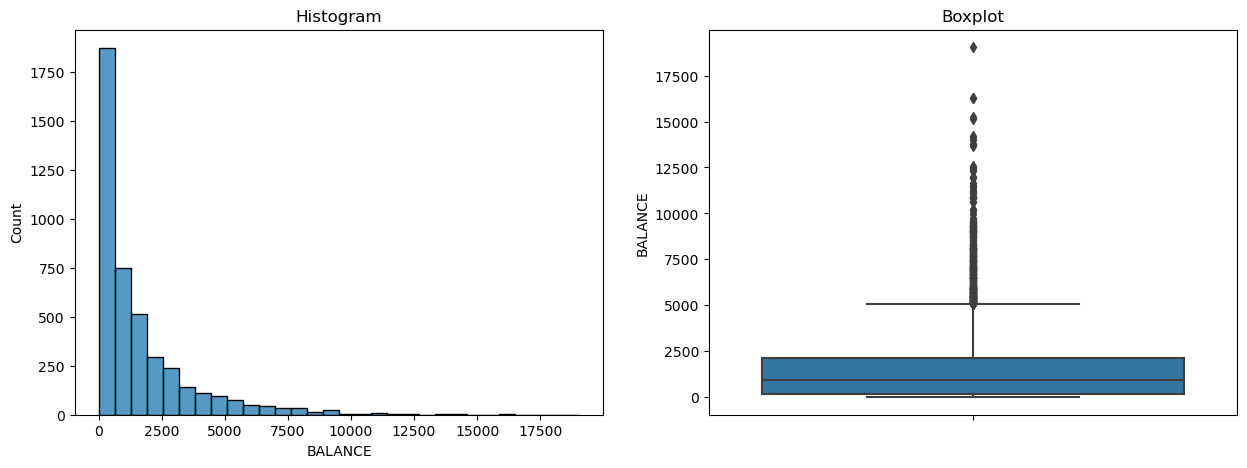


BALANCE - After Capping


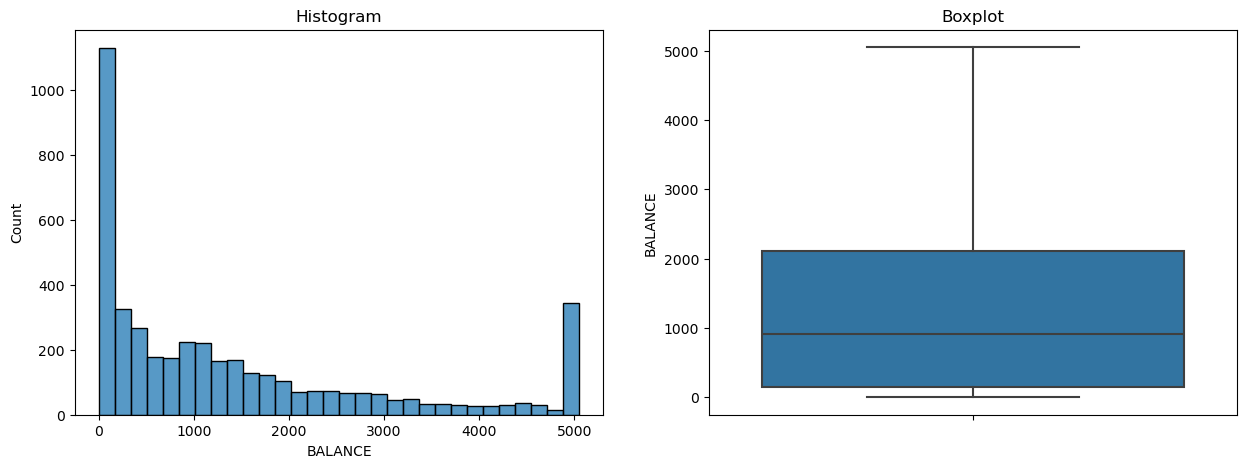

BALANCE_FREQUENCY - Before Capping


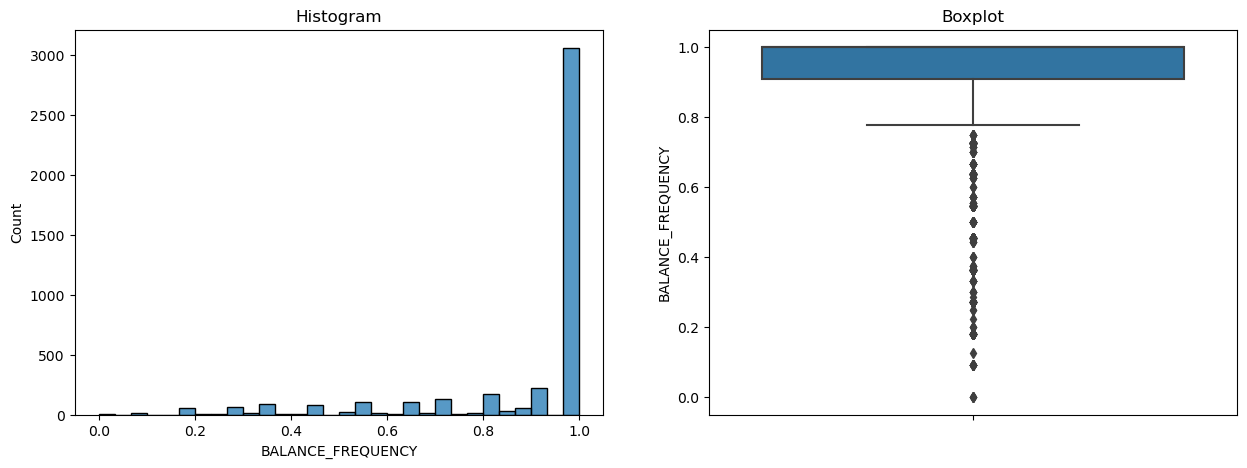


BALANCE_FREQUENCY - After Capping


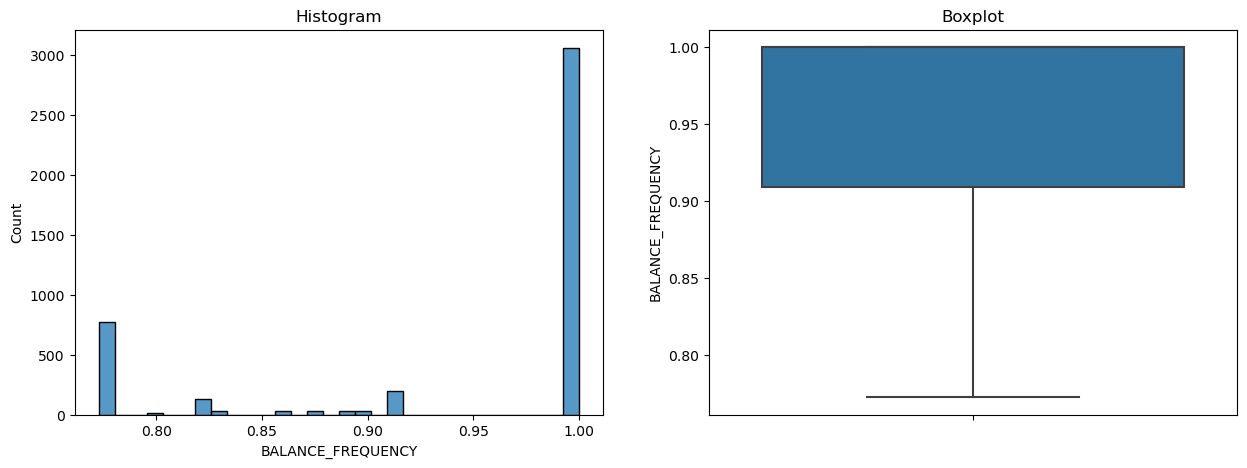

PURCHASES - Before Capping


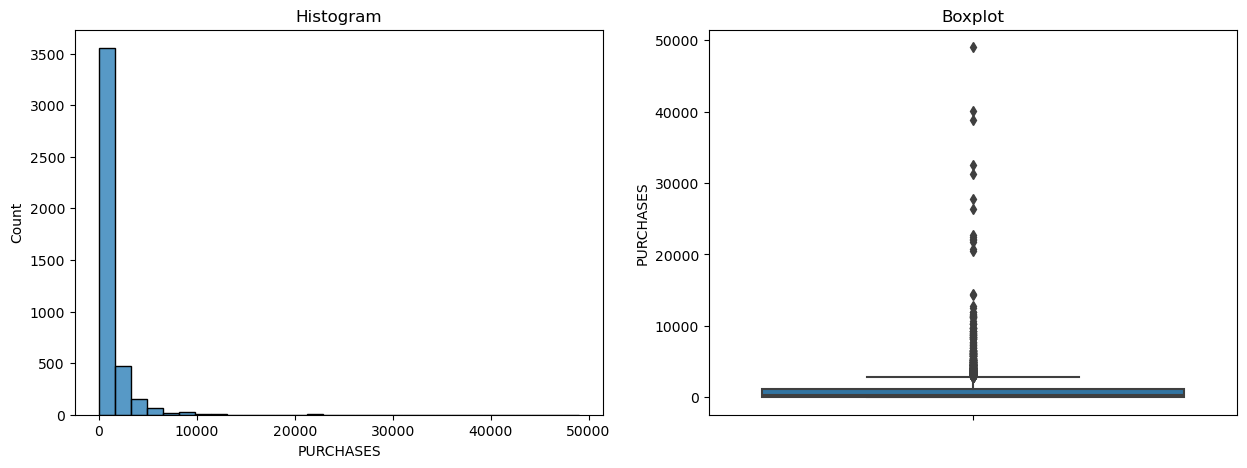


PURCHASES - After Capping


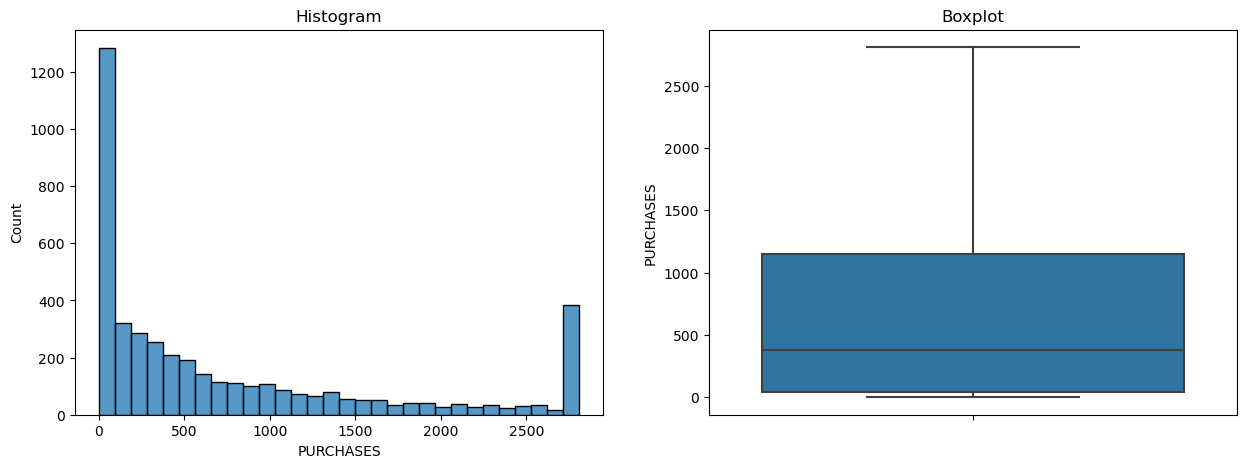

ONEOFF_PURCHASES - Before Capping


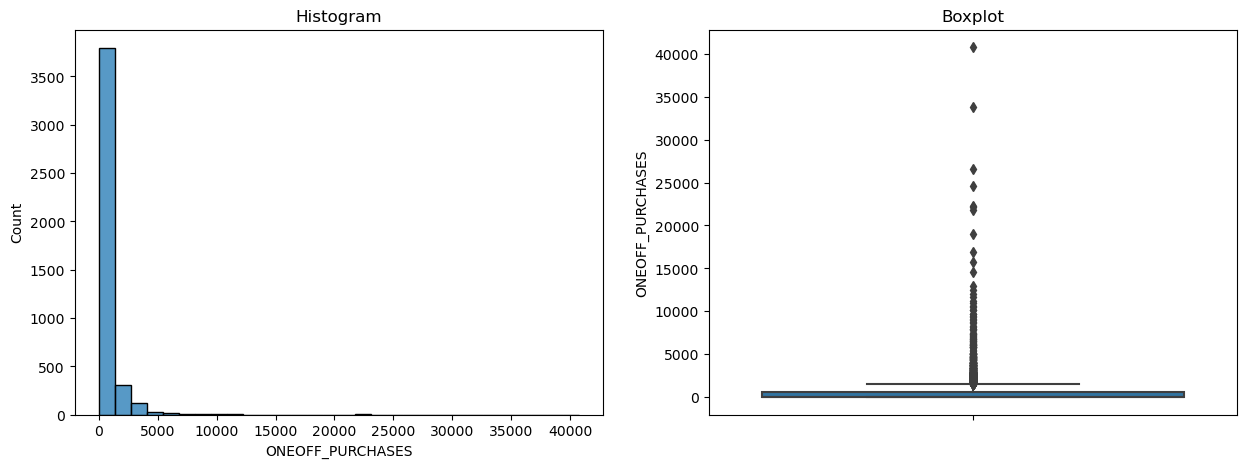


ONEOFF_PURCHASES - After Capping


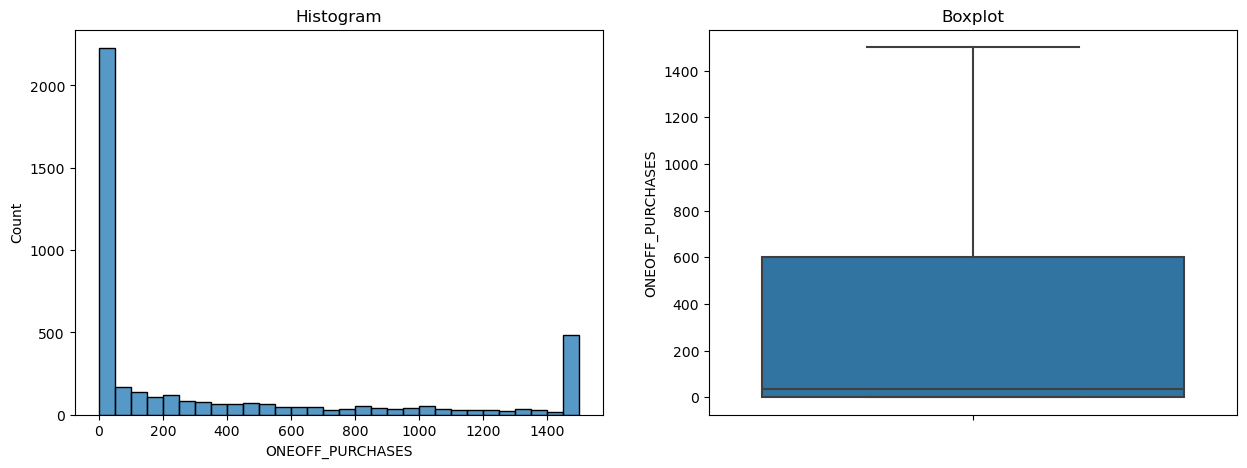

INSTALLMENTS_PURCHASES - Before Capping


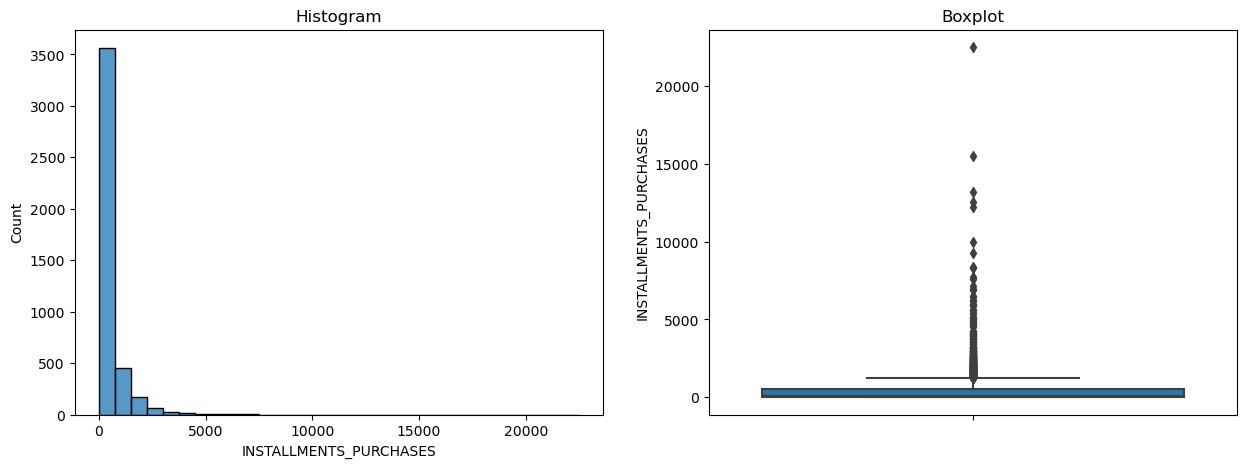


INSTALLMENTS_PURCHASES - After Capping


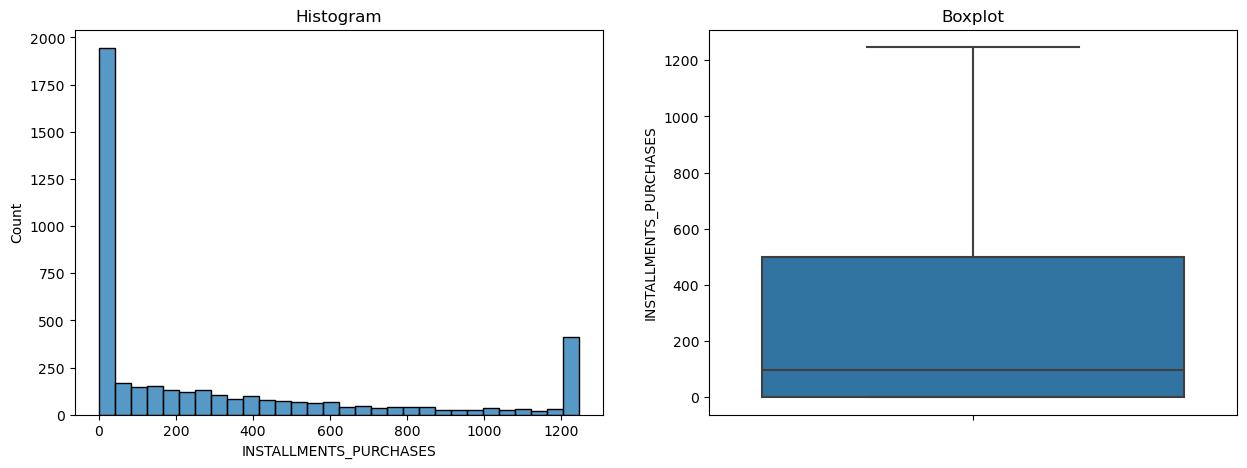

CASH_ADVANCE - Before Capping


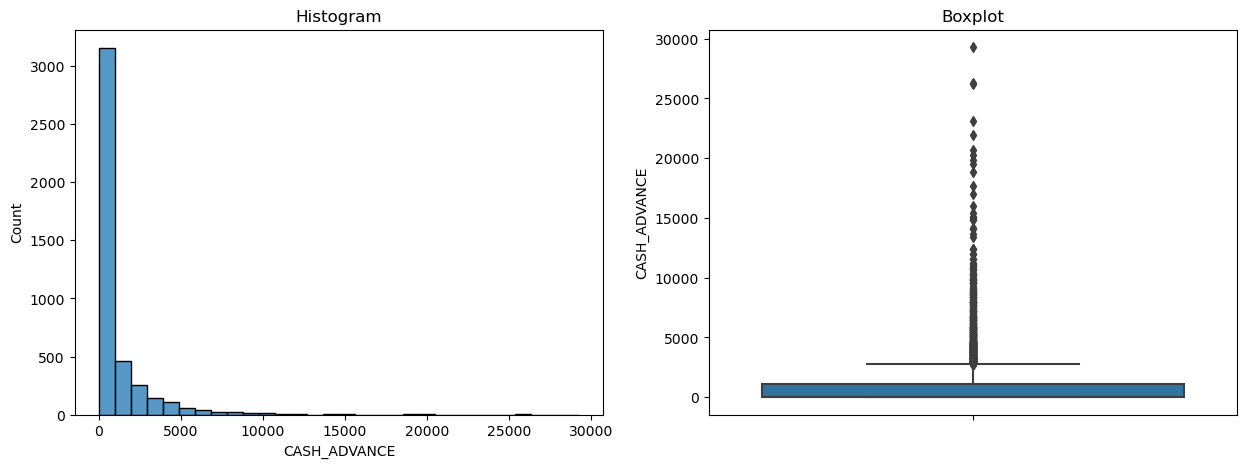


CASH_ADVANCE - After Capping


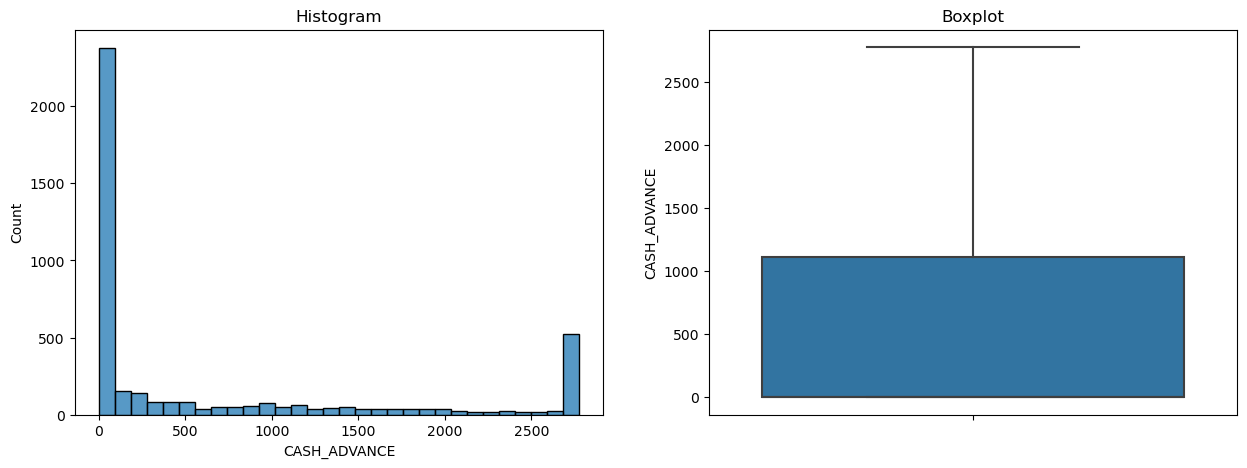

CASH_ADVANCE_FREQUENCY - Before Capping


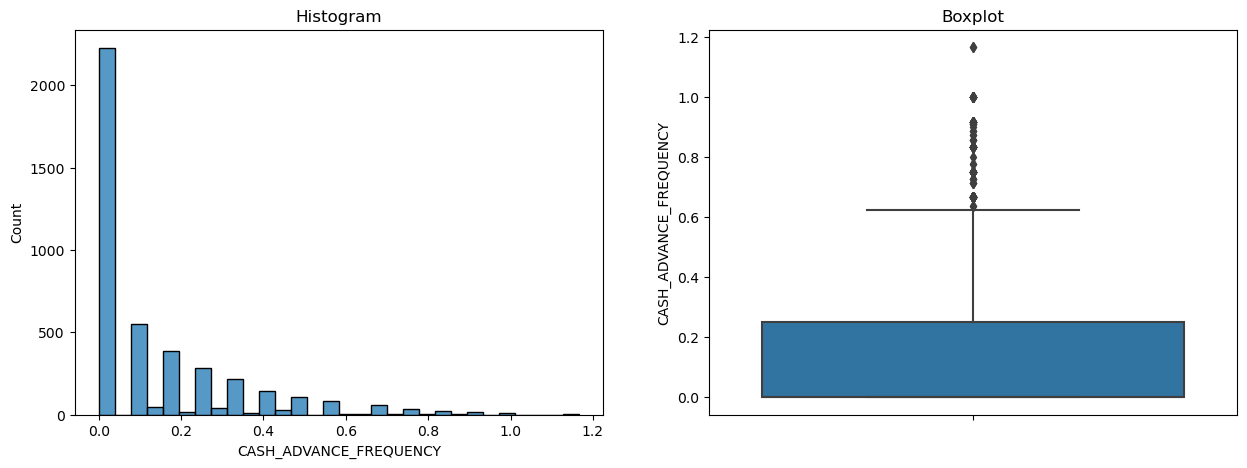


CASH_ADVANCE_FREQUENCY - After Capping


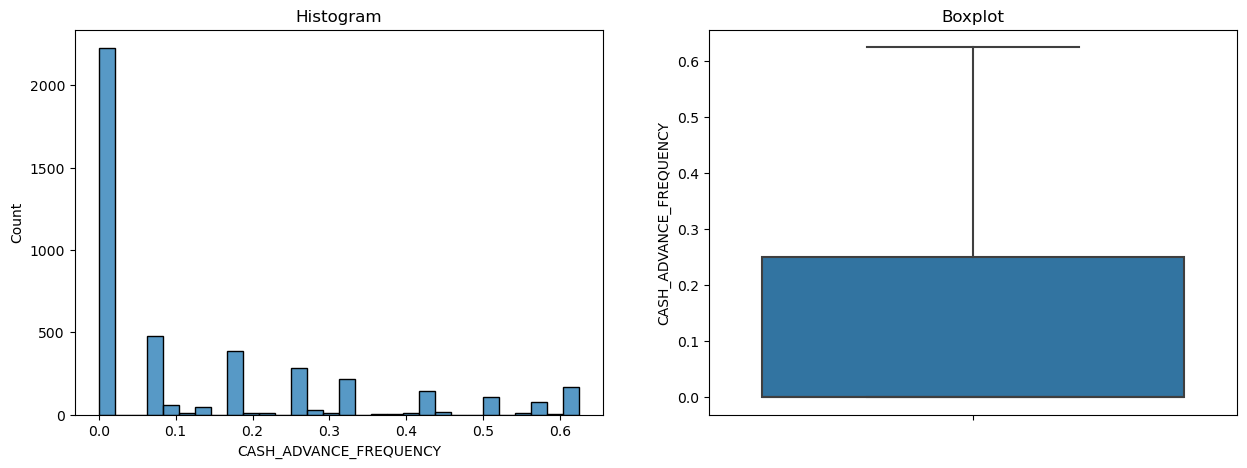

CASH_ADVANCE_TRX - Before Capping


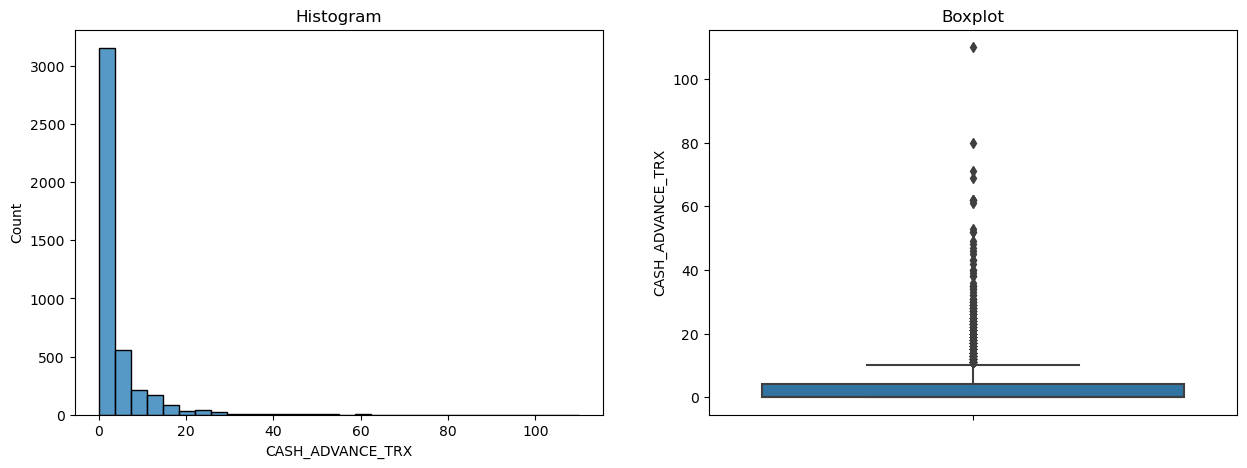


CASH_ADVANCE_TRX - After Capping


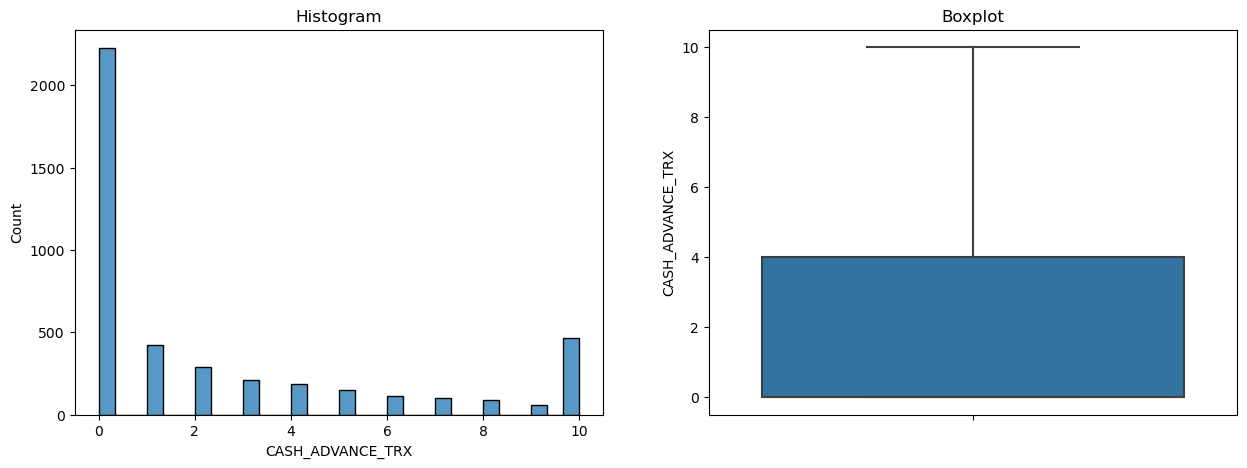

PURCHASES_TRX - Before Capping


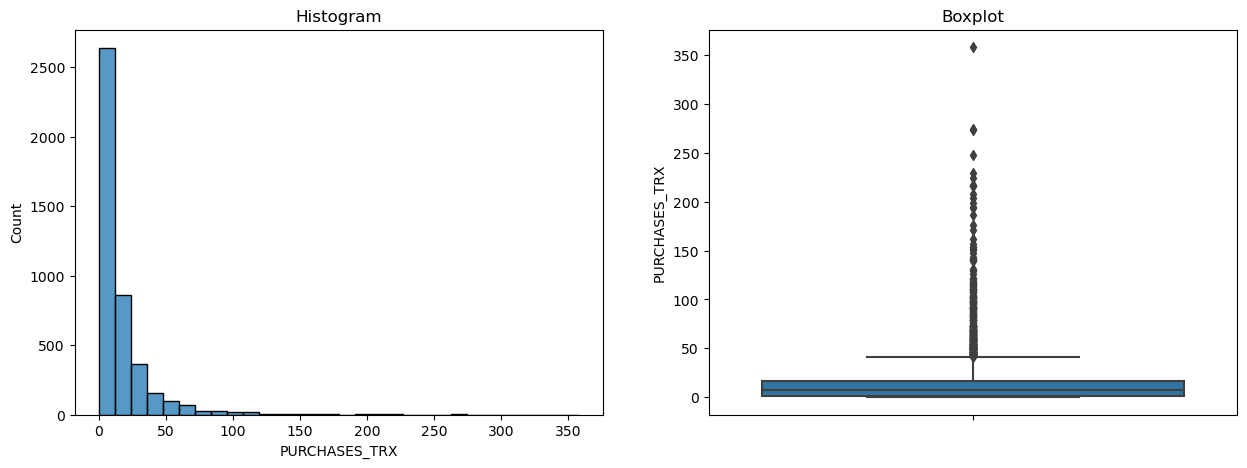


PURCHASES_TRX - After Capping


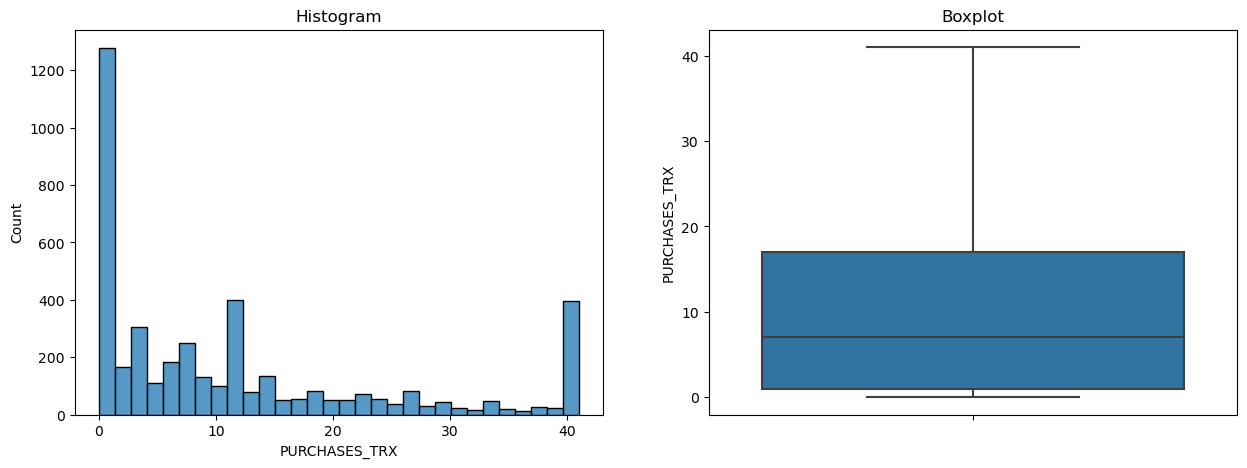

CREDIT_LIMIT - Before Capping


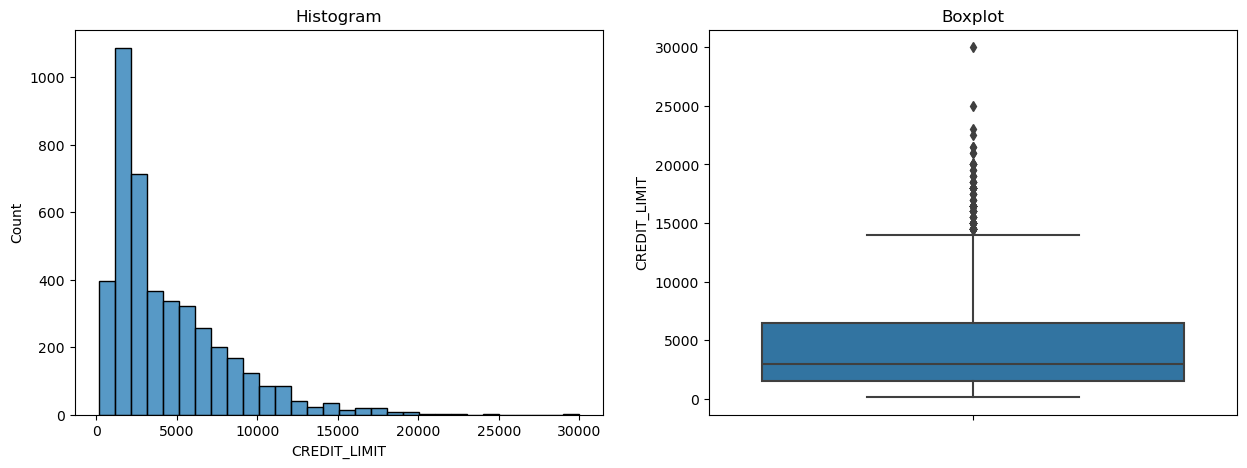


CREDIT_LIMIT - After Capping


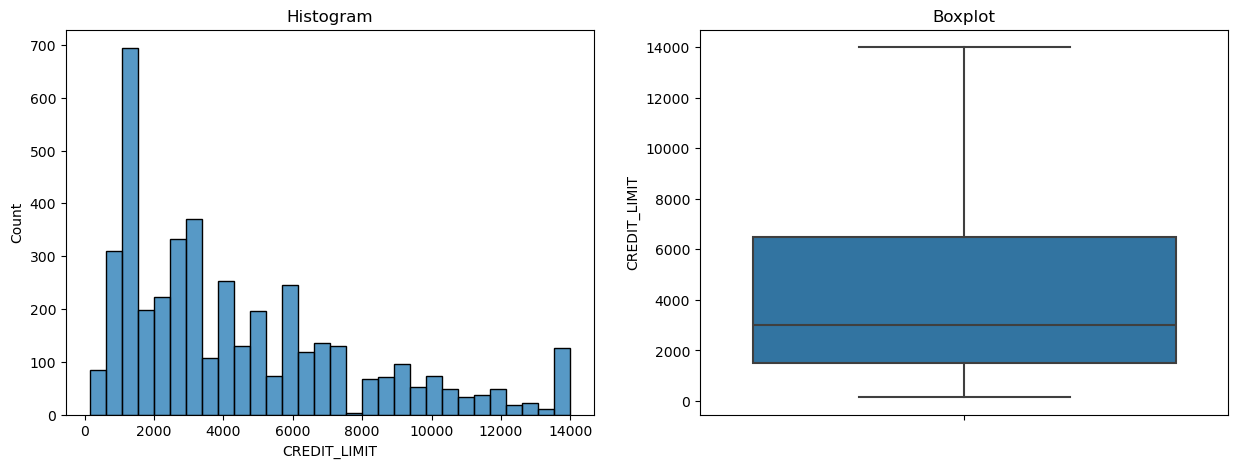

PAYMENTS - Before Capping


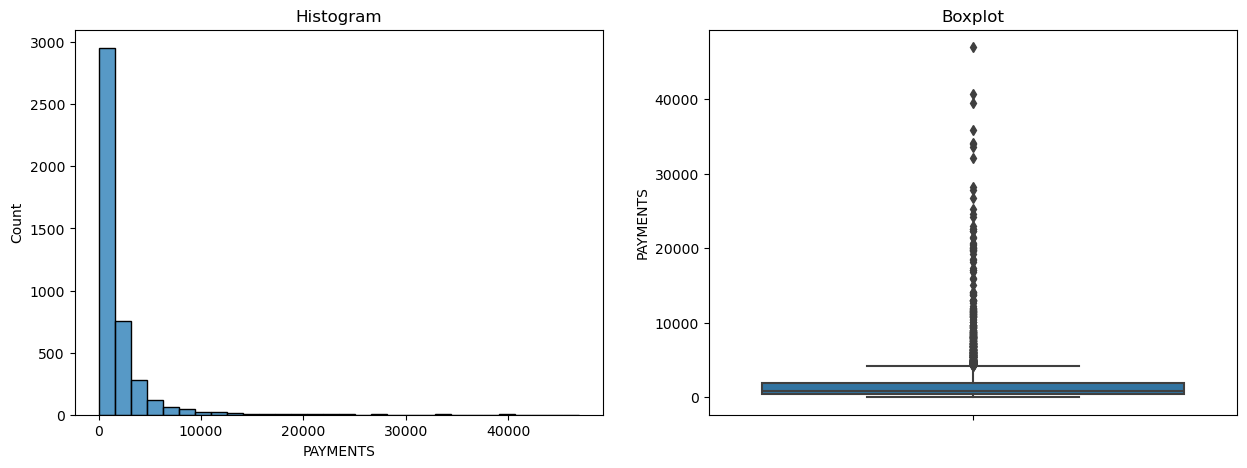


PAYMENTS - After Capping


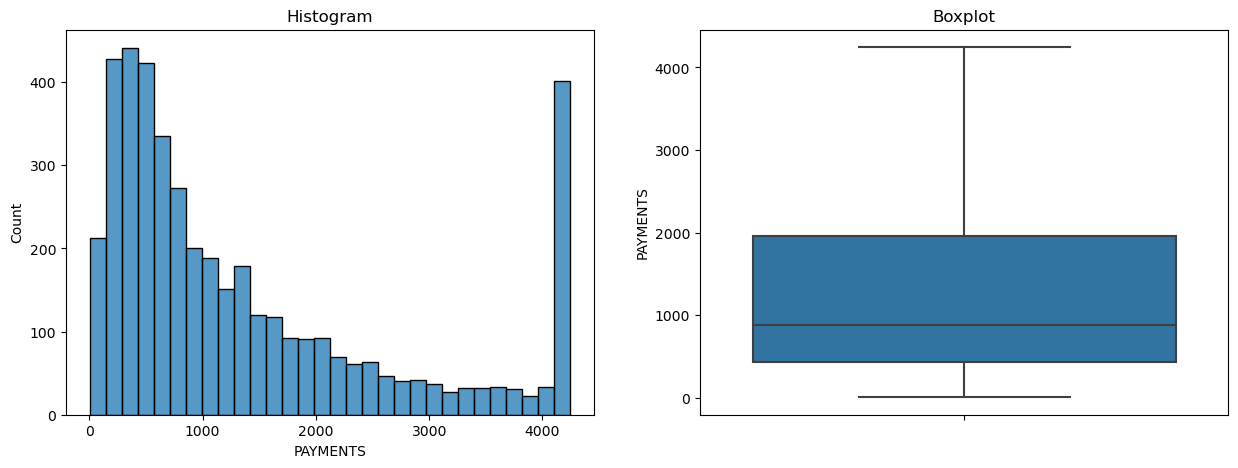

MINIMUM_PAYMENTS - Before Capping


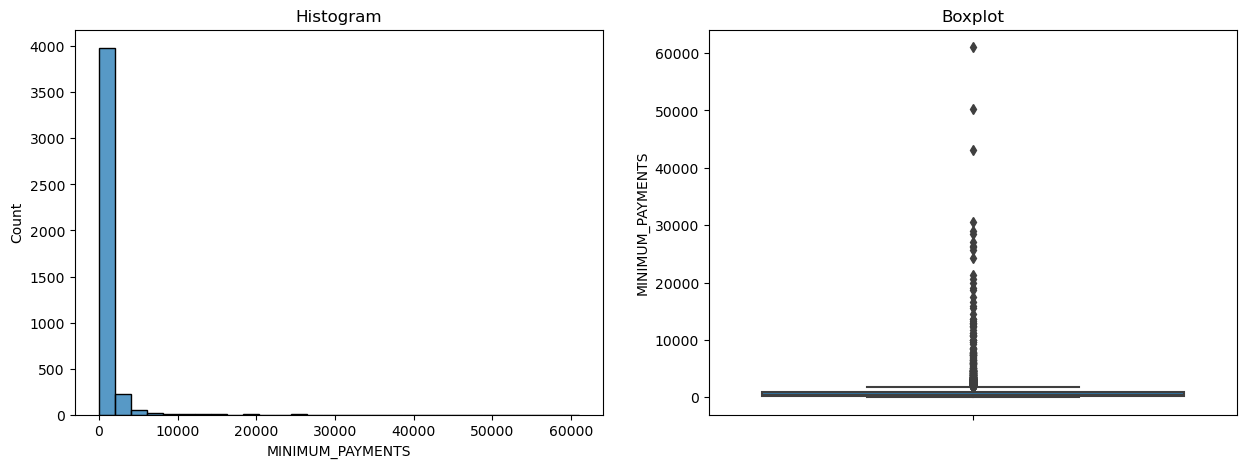


MINIMUM_PAYMENTS - After Capping


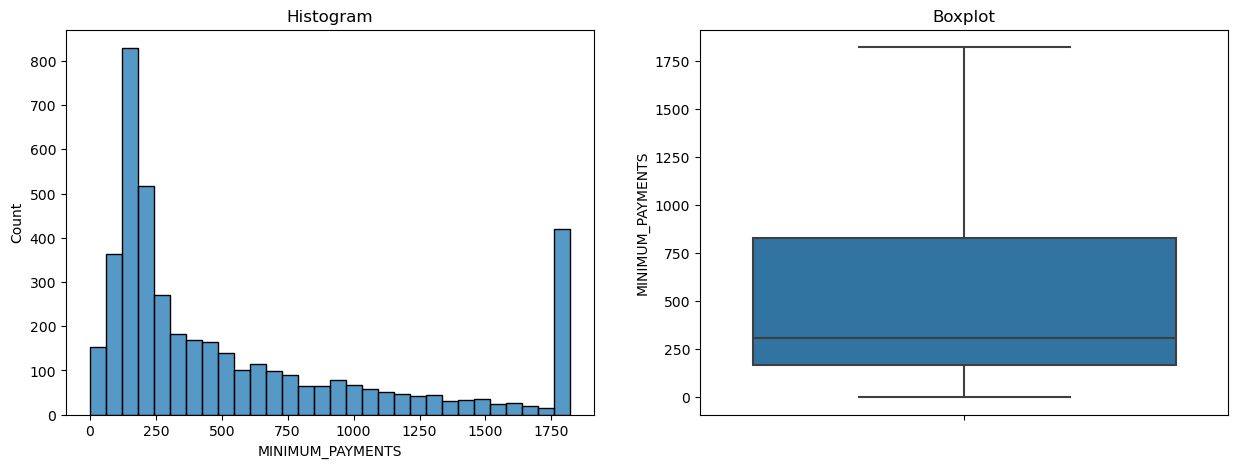

PRC_FULL_PAYMENT - Before Capping


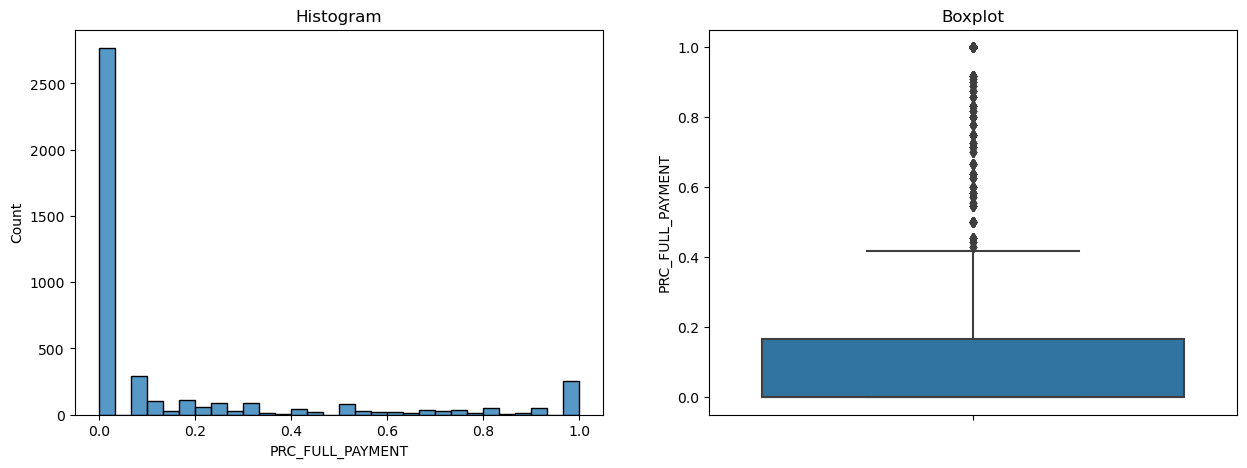


PRC_FULL_PAYMENT - After Capping


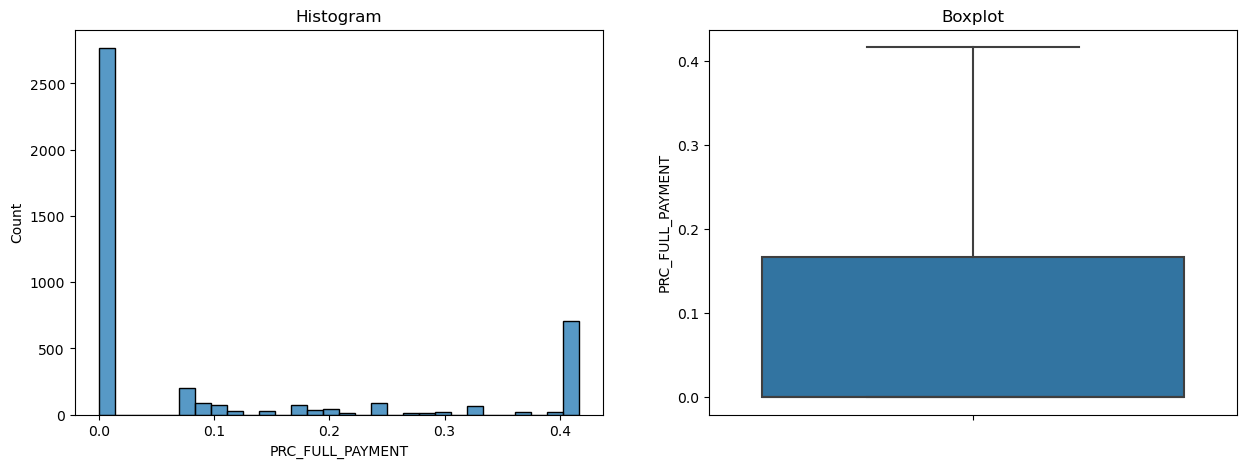

In [97]:
# function for histogram and boxplot
def diagnostic_plots(df, variable):
    # fefine figure size
    plt.figure(figsize=(15, 5))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

# loop outlier columns
for col in outlier_column_skew:
    # plot before capping
    print(f'{col} - Before Capping')
    diagnostic_plots(df2, col)

    # plot after capping
    print(f'\n{col} - After Capping')
    diagnostic_plots(df2_capped, col)

## 6.4. Feature Scaling & Dimensionality Reduction

Scaling fitur numerik agar dapat diproses oleh PCA, menggunakan MinMaxScaler karena mayoritas data bersifat skew

In [98]:
# feature scaling
scaler = MinMaxScaler()
df2_scaled = scaler.fit_transform(df2_capped)
df2_scaled

array([[0.18678169, 0.44999945, 0.03668279, ..., 0.04963624, 0.22529924,
        0.        ],
       [0.09134478, 1.        , 0.208344  , ..., 0.05970756, 0.08324724,
        0.        ],
       [0.20855821, 1.        , 0.5164082 , ..., 0.0925002 , 0.12466085,
        0.        ],
       ...,
       [0.67035309, 1.        , 0.19978943, ..., 0.24387539, 0.48634269,
        0.        ],
       [0.95818202, 1.        , 0.56838024, ..., 0.21247472, 1.        ,
        0.21818116],
       [0.39134693, 1.        , 0.36755443, ..., 0.7196248 , 0.49987737,
        0.21818116]])

Pengurangan dimensi atau fitur dengan PCA setelah data selesai scaling

In [99]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df2_scaled)

PCA()

Plot visualisasi untuk melihat jumlah komponen yang dibutuhkan berdasarkan persentase informasi yang diinginkan

Text(0, 0.5, 'Eigenvalues')

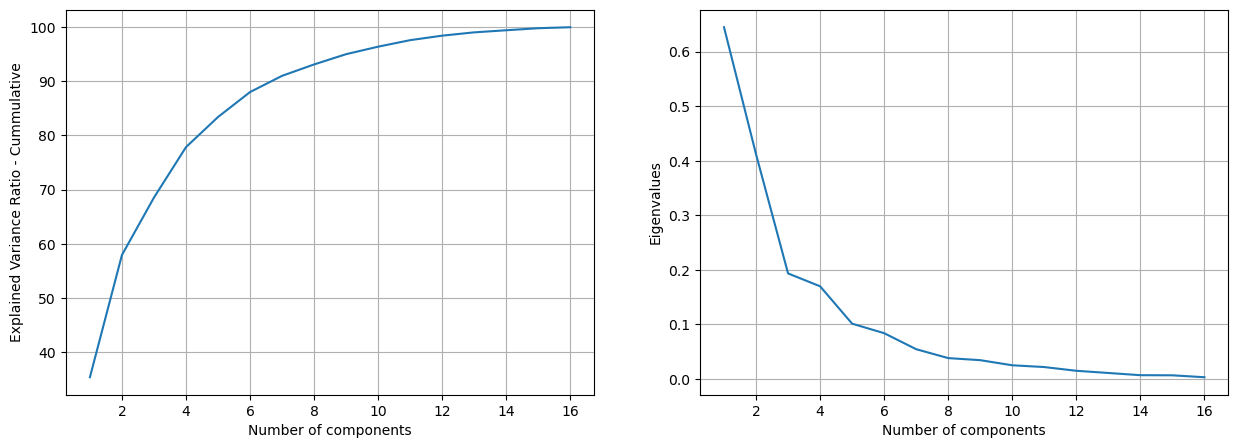

In [100]:
# plot the cummulative of explained variance ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 17), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# plot the eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 17), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

Insight:
- Grafik sebelah kiri atau 'Explained Variance Plot' bertujuan menyimpan variansi sebanyak mungkin sehingga terlihat bahwa pada garis sekitar 95% dibutuhkan sekitar 10-12 komponen.
- Sementara grafik sebelah kanan 'Scree Plot' bertujuan mencari titik dimana informasi yang didapatkan dari tiap penambahan komponen semakin menurun. Terlihat dari titik 5-12 garis semakin melandai yang menandakan informasi yang didapat semakin menurun.

Cek jumlah komponen yang terbaik untuk mempertahankan 95% informasi

In [101]:
# check number of features for 95% info
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

9

Insight:
- 9 komponen merupakan jumlah yang optimal untuk mempertahankan 95% informasi dari dataset

Mengubah dataset yang sudah scaling dengan pengurangan dimensi PCA 95%

In [102]:
# train model with 95% PCA
pca = PCA(n_components=0.95)
pca.fit(df2_scaled)

df2_pca = pca.transform(df2_scaled)
df2_pca

array([[-0.58932545, -0.62916181,  0.05606385, ...,  0.01013551,
        -0.10051896,  0.0242882 ],
       [-0.39416   , -0.44426998,  0.02137624, ...,  0.23746099,
        -0.04176252, -0.04069364],
       [-0.14554262, -0.20962072,  0.34793453, ...,  0.28485027,
        -0.19579909, -0.14799427],
       ...,
       [-0.06240035,  1.11540144, -0.02611304, ..., -0.62905003,
         0.26211638, -0.11344603],
       [-0.29988744,  1.56926382,  0.51078257, ..., -0.48244382,
        -0.49803544, -0.26047062],
       [ 0.10834608,  1.09117138, -0.33936428, ...,  0.1548837 ,
         0.0036047 ,  0.14440233]])

# 7. Model Definition

Clustering menggunakan K-Means, mencari jumlah cluster yang tepat untuk dataset berdasarkan elbow method dan silhouette score.

## 7.1. Elbow Method

Cek jumlah cluster yang tepat berdasarkan Elbow Method

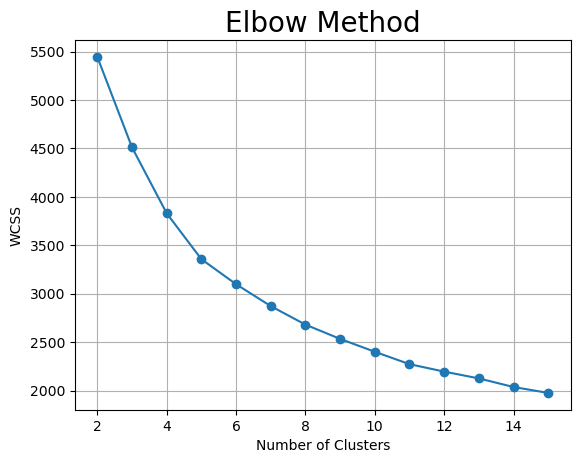

In [103]:
# find the optimal number of clusters using elbow method
wcss = []
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 30)
    km.fit(df2_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Insight:
- Dari grafik kurang terlihat titik elbow atau siku yang jelas
- Perlu menggunakan metode lain untuk menemukan jumlah cluster yang tepat

## 7.2. Silhouette Score

Cek plot dan skor Silhouette untuk dataset tiap cluster dari 2-15

In [104]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

In [ ]:
# run function on data with random state 30
plot_silhouette(range(2, max_cluster), df2_pca, 30)

Insight:
- Cluster dengan skor silhouette adalah 2
- Namun dari visualisasi terlihat bahwa cluster 2 memiliki visualisasi yang kurang baik dan terlihat padat
- Berdasarkan visualisasi, cluster-cluster dengan persebaran yang lebih baik adalah 3-5
- Berdasarkan nilai antara cluster 3-5, terlihat bahwa nilai tertinggi terdapat pada cluster 5

# 8. Model Training

Setelah menentukan jumlah cluster yang optimal, dilakukan training pada model berdasarkan parameter tersebut. Hasil clustering kemudian didapat setelah menggunakan fit_predict.

In [106]:
# train with optimal number of clusters
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 30)
pred = km.fit_predict(df2_pca)
pred

array([2, 2, 2, ..., 4, 4, 4], dtype=int32)

Hasil clustering kemudian dimasukkan ke dalam dataset awal

In [107]:
# insert clustering result into original dataset
df2['cluster'] = pred
df2

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
0,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,2
1,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,2
2,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,2
3,2237.238086,1.000000,120.00,120.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,2500.0,343.102984,712.986387,0.000000,2
4,424.994385,0.375000,1200.00,1200.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1200.0,57.266292,56.720210,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,4
4312,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,4
4313,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,4
4314,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,4


Visualisasi data setelah clustering sesuai jumlah cluster yang dipilih

<Axes: >

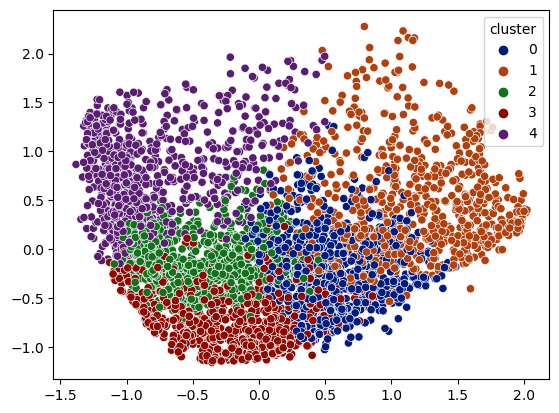

In [108]:
# cluster visualization in 2D
pca_2d = PCA(n_components=0.95)
pca_2d.fit(df2_pca)
df2_scaled_pca_2d = pca_2d.fit_transform(df2_pca)

# visualization
sns.scatterplot(x=df2_scaled_pca_2d[:,0], y=df2_scaled_pca_2d[:,1], hue=df2['cluster'], palette='dark')

Insight:
- Hasil visualisasi data setelah clustering dalam bentuk 2d
- Terbagi menjadi 5 cluster
- Terdapat beberapa data yang saling bertumpuk dapat menandakan batasan cluster yang kurang jelas
- Namun juga bisa data overlap tersebut ada karena simplikasi data menjadi visualisasi 2d

# 9. Cluster Analysis

In [109]:
# group by the 'cluster' column & calculate mean 
clusterdf = df2.groupby('cluster').mean()

# make dataframe
clusterdf = pd.DataFrame(clusterdf)

# count the number of occurrences of each cluster
counts = df2['cluster'].value_counts().sort_index()

# calculate the percentage of each cluster
percentages = (counts / counts.sum()) * 100

# add count and percentage columns to the means DataFrame
clusterdf['Count_Cluster'] = counts
clusterdf['Percentage_Data'] = percentages

# display the resulting DataFrame
clusterdf = clusterdf.reset_index()
clusterdf

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
0,0,749.987075,0.965787,822.836093,115.640155,708.187370,159.123988,0.919509,0.091251,0.862158,0.035746,0.678135,19.234184,3270.588235,965.714958,811.578701,0.262377,901,20.875811
1,1,2184.423447,0.981659,3828.932050,2548.012999,1280.986451,600.024797,0.912803,0.684205,0.659177,0.077180,1.880330,47.856946,7409.768663,3776.725627,949.843557,0.247881,727,16.844300
2,2,1409.911857,0.991764,271.381276,230.177502,41.546652,370.808904,0.203852,0.134118,0.071836,0.111262,1.799095,3.809050,3021.628959,745.028044,813.826261,0.012605,1105,25.602410
3,3,191.686311,0.540579,431.444144,262.531322,169.258917,340.806153,0.316172,0.103421,0.201894,0.042202,0.736776,5.044081,3729.023230,1280.230257,180.844044,0.305135,794,18.396664
4,4,3716.259183,0.956752,326.528454,219.939125,106.674183,3802.124022,0.216670,0.097287,0.127213,0.435010,12.024081,4.498099,6202.788340,2854.210693,1551.230714,0.038882,789,18.280816


## 9.1. Cluster 0

In [110]:
# check data for cluster 0
clusterdf[clusterdf['cluster']==0]

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
0,0,749.987075,0.965787,822.836093,115.640155,708.18737,159.123988,0.919509,0.091251,0.862158,0.035746,0.678135,19.234184,3270.588235,965.714958,811.578701,0.262377,901,20.875811


### CLUSTER 0: Kelas Menengah, Transaksi Sering, Jumlah Reguler
- Tabungan yang menengah, bukan paling rendah
- Jumlah pembelian relatif tinggi untuk tabungannya
- Sangat sering melakukan pembelian
- Proporsi pembelian besar pada cicilan
- Jarang melakukan penarikan uang tunai
- Jumlah transaksi tinggi
- Namun pembayaran rendah menandakan penggunaan kredit untuk hal-hal dengan harga rendah

## 9.2. Cluster 1

In [111]:
# check data for cluster 1
clusterdf[clusterdf['cluster']==1]

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
1,1,2184.423447,0.981659,3828.93205,2548.012999,1280.986451,600.024797,0.912803,0.684205,0.659177,0.07718,1.88033,47.856946,7409.768663,3776.725627,949.843557,0.247881,727,16.8443


### CLUSTER 1: Kelas Atas, Transaksi Tinggi, Jumlah Tinggi
- Memiliki tabungan yang tinggi
- Jumlah pembelian sangat tinggi, tertinggi dari cluster lain
- Sangat sering melakukan pembelian
- Proporsi pembelian sering melalui cicilan ataupun langsung lunas
- Jarang sekali menggunakan uang tunai
- Jumlah transaksi tinggi
- Pembayaran tinggi menandakan pembelian berupa barang-barang yang lebih mahal

## 9.3. Cluster 2

In [112]:
# check data for cluster 2
clusterdf[clusterdf['cluster']==2]

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
2,2,1409.911857,0.991764,271.381276,230.177502,41.546652,370.808904,0.203852,0.134118,0.071836,0.111262,1.799095,3.80905,3021.628959,745.028044,813.826261,0.012605,1105,25.60241


### CLUSTER 2: Kelas Menengah, Transaksi Jarang, Aktifitas Finansial Rendah
- Tabungan menengah
- Aktifitas finansial rendah
- Jarang bertransaksi
- Jarang melakukan penarikan uang tunai juga

## 9.4. Cluster 3

In [113]:
# check data for cluster 3
clusterdf[clusterdf['cluster']==3]

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
3,3,191.686311,0.540579,431.444144,262.531322,169.258917,340.806153,0.316172,0.103421,0.201894,0.042202,0.736776,5.044081,3729.02323,1280.230257,180.844044,0.305135,794,18.396664


### CLUSTER 3: Kelas Menengah Kebawah, Transaksi Moderat, Tunai Tinggi
- Tabungan rendah
- Jumlah pembelian cukup lebih besar dari tabungan
- Relatif jarang menggunakan cicilan, lebih mengutamakan langsung lunas atau tunai
- Keseringan pembelian 30% tidak terlalu sering
- Jumlah transaksi cukup rendah

## 9.5. Cluster 4

In [114]:
# check data for cluster 4
clusterdf[clusterdf['cluster']==4]

,cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Count_Cluster,Percentage_Data
4,4,3716.259183,0.956752,326.528454,219.939125,106.674183,3802.124022,0.21667,0.097287,0.127213,0.43501,12.024081,4.498099,6202.78834,2854.210693,1551.230714,0.038882,789,18.280816


### CLUSTER 4: Kelas Atas, Transaksi Jarang, Tunai Tinggi
- Nilai tabungan sangat tinggi, tertinggi antara cluster lain
- Jumlah pembelian sangat rendah, apalagi dibandingkan tabungan
- Nilai penarikan tunai tinggi
- Jarang bertransaksi selain ambil tunai
- Nilai pembayaran tinggi menandakan meski jarang pembelian, jika beli untuk barang dengan harga tinggi

## 9.6. Visualisasi

Visualisasi data setelah clustering agar mudah mencerna informasi yang didapat, dimulai dengan menyalin data cluster.

In [115]:
clusterdf2 = clusterdf.copy()

Mapping nama-nama cluster agar mudah dibaca dan tidak berbentuk angka 0-4

In [116]:
# mapping cluster names
urutan = {0: 'Kelas Menengah, Transaksi Tinggi', 1: 'Kelas Atas, Transaksi Tinggi', 
          2: 'Kelas Menengah, Transaksi Rendah', 3: 'Kelas Menengah Kebawah, Transaksi Moderat', 
          4: 'Kelas Atas, Transaksi Rendah'}

# set cluster names
clusterdf2['cluster'] = clusterdf2['cluster'].map(urutan)

### 9.6.1. Proporsi Cluster

Cek proporsi cluster terhadap dataset

In [117]:
# pie chart figure
fig = px.pie(clusterdf2, names="cluster", 
              values="Count_Cluster", 
              title="Proporsi Cluster") 
fig.update_layout(title_x = 0.5)

# display pie chart
fig.show()

Insight:
- Terlihat persebaran cluster cukup rata
- Tertinggi pada cluster Menengah dengan Transaksi Rendah
- Disusul cluster Menengah dengan Transaksi Tinggi
- Paling kecil adalah cluster Atas, Transaksi Tinggi

### 9.6.2. Rata-rata Tabungan Cluster

Cek nilai rata-rata tabungan tiap cluster

In [118]:
# bar chart
fig = px.bar(clusterdf2, x="BALANCE", y="cluster", orientation='h', text_auto='.2s', title='Rata-rata Tabungan Cluster', color="cluster")
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Rata-rata Tabungan")
fig.update_traces(showlegend=False)

# display bar chart and grouping data
fig.show()

Insight:
- Terlihat perbedaan signifikan antar cluster berdasarkan jumlah tabungan
- Terlihat juga cluster 'Kelas Atas, Transaksi Rendah' memiliki banyak tabungan dan aktifitas finansial yang relatif rendah
- Begitu juga pada 'Kelas Menengah, Transaksi Rendah' memiliki tabungan yang signifikan yang jarang digunakan untuk transaksi pembelian

### 9.6.3. Rata-rata Jumlah Pembelian

Cek nilai rata-rata jumlah pembelian tiap cluster

In [119]:
# bar chart
fig = px.bar(clusterdf2, x="PURCHASES", y="cluster", orientation='h', text_auto='.2s', title='Rata-rata Jumlah Pembelian Cluster', color="cluster")
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Rata-rata Jumlah Pembelian")
fig.update_traces(showlegend=False)

# display bar chart and grouping data
fig.show()

Insight:
- Terlihat cluster 'Kelas Atas, Transaksi Tinggi' memiliki jumlah pembelian tertinggi jauh di atas cluster lain
- Kembali terlihat pada cluster 'Kelas Atas, Transaksi Rendah' dan 'Kelas Menengah, Transaksi Rendah' rendahnya aktifitas finansial

### 9.6.4. Rata-rata Keseringan Pembelian Cicilan

Cek rata-rata keseringan pembelian menggunakan metode cicilan untuk tiap cluster

In [120]:
# bar chart
fig = px.bar(clusterdf2, x="PURCHASES_INSTALLMENTS_FREQUENCY", y="cluster", orientation='h', text_auto='.2f', title='Rata-rata Keseringan Pembelian Cicilan Cluster', color="cluster")
fig.update_layout(title_x = 0.5)
fig.update_xaxes(title_text="Rata-rata Keseringan Pembelian Cicilan")
fig.update_traces(showlegend=False)

# display bar chart and grouping data
fig.show()

Insight:
- Kembali terlihat bahwa cluster 'Kelas Atas, Transaksi Rendah' dan 'Kelas Menengah, Transaksi Rendah' memiliki frekuensi paling rendah.
- Sedangkan kedua kluster transaksi tinggi memiliki frekuensi penggunaan
 cicilan yang tinggi

# 10. Model Saving

Penyimpanan model dengan pickle

In [122]:
# save model with pickle
with open('model.pkl', 'wb') as file_1:
    pickle.dump(km, file_1)

with open('scaler.pkl', 'wb') as file_2:
    pickle.dump(scaler, file_2)

with open('pca.pkl', 'wb') as file_3:
    pickle.dump(pca, file_3)

with open('list_cols.txt', 'wb') as file_4:
    pickle.dump(list_cols, file_4)

# 11. Kesimpulan & Rekomendasi

**Kesimpulan**

Dengan menggunakan metode PCA dan K-Means, ditemukan bahwa 5 cluster merupakan pembagian cluster yang optimal untuk dataset. Setelah dataset terbagi menjadi 5 cluster, kemudian dilakukan analisis tiap cluster untuk menemukan ciri-ciri yang menggambarkan cluster tersebut. Hasil dari analisis membagi cluster menjadi:
1. 'Kelas Menengah, Transaksi Tinggi'; data dalam cluster ini memiliki ciri tabungan dengan jumlah moderat, aktifitas finansial tinggi, serta penggunaan metode cicilan yang tinggi.

2. 'Kelas Atas, Transaksi Tinggi'; data dalam cluster ini memiliki ciri tabungan dengan jumlah tinggi, aktifitas finansial tinggi juga, dan penggunaan metode cicilan yang cukup tinggi.

3. 'Kelas Menengah, Transaksi Rendah'; data dalam cluster ini berciri memiliki tabungan dengan jumlah menengah, namun dengan aktifitas finansial yang rendah, sehingga uang tetap dalam tabungan.

4. 'Kelas Menengah Kebawah, Transaksi Moderat'; data dalam cluster ini berciri memiliki tabungan dengan jumlah cukup rendah, dengan aktifitas finansial yang cukup relatif dengan jumlah tabungan, serta penggunaan uang tunai yang lebih tinggi.

5. 'Kelas Atas, Transaksi Rendah'; data dalam cluster ini memiliki ciri tabungan tertinggi, namun aktifitas finansial sangat rendah. Kebanyakan aktifitas finansial berasal dari tarikan tunai.

**Rekomendasi**

Berdasarkan kesimpulan di atas dapat direkomendasikan beberapa hal:
- Untuk meningkatkan penggunaan bagi cluster dengan aktifitas finansial tinggi, dapat dibuat program loyalitas. Dimana semakin sering transaksi, terkumpul poin-poin loyalitas semakin besar dan semakin banyak benefit yang didapat.

- Untuk segmen menengah dengan aktifitas finansial rendah, perlu dibuat program dimana terlihat jelas keuntungan menggunakan kartu kredit dengan insentif yang menarik. Contohnya program-program diskon pada restoran atau bioskop.

- Sementara cluster atas dengan aktifitas rendah, dapat dilakukan hal yang sama berupa program insentif namun dengan insentif yang sesuai kelasnya. Seperti halnya diskon atau benefit dengan maskapai penerbangan untuk harga tiket, fasilitas, maupun atau pengumpulan poin maskapai tersebut.

# 12. Conceptual Problem

1. Apa yang dimaksud dengan inertia pada algoritma K-Means:

Inertia bertujuan mengukur seberapa seberapa baik suatu dataset dapat dibagi menjadi cluster-cluster oleh K-Means. Pengukuran inertia dilakukan mengukur jarak antara titik data dengan centroidnya. Model yang baik adalah model dengan nilai inertia yang rendah dan jumlah cluster yang sedikit. Namun ini balik lagi harus ditentukan sendiri, karena semakin tinggi cluster, nilai inertia semakin rendah.

2. Jelaskan yang dimaksud dengan Elbow Method:

Elbow Method adalah sebuah metode untuk menemukan jumlah cluster yang optimal untuk model. Cara penggunaannya adalah menguji setiap cluster dalam rentang yang spesifik (contoh 2-15) dan plotting skor inersia tiap clusternya. Setelah dilakukan plotting, dicarilah titik elbow point atau siku dimana penurunan nilai inertia sudah mulai merata atau tidak berkurang secara signifikan lagi. Titik elbow point tersebutlah jumlah cluster yang optimal. Kelebihan dari metode ini adalah kemudahan penggunaan karena berbentuk visual maka mudal melihat titik yang tepat. Namun kekurangannya berada jika titik elbow point tidak terlihat jelas sehingga menjadi penilaian subjektif.